In [1]:
import numpy as np
from copy import copy
from scipy.sparse import lil_matrix, linalg
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import cv2
import scipy.io as sio

### Constants

### The Images

In [2]:
mdict = sio.loadmat("./imgs_for_optical_flow.mat")
img1 = mdict["img1"]
img2 = mdict["img2"]
img3 = mdict["img3"]
img4 = mdict["img4"]
img5 = mdict["img5"]
img6 = mdict["img6"]

N_rows = img1.shape[0]
N_cols = img1.shape[1]
N = N_rows*N_cols

I_t_arr = [img2 - img1, img3 - img1, img4 - img1, img5 - img1, img6 - img1]
dest_arr = [img2, img3, img4, img5, img6]

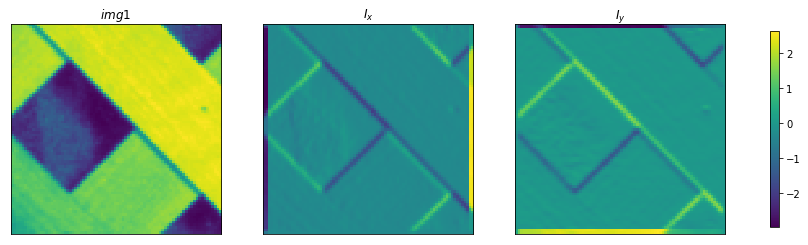

In [3]:
h1,h2 = cv2.getDerivKernels(1,0,3)
h_x = h2.dot(h1.T)
# print(h_x)
h1,h2 = cv2.getDerivKernels(0,1,3)
h_y = h2.dot(h1.T)
# print(h_y)
I_x = convolve2d(img1, h_x)
I_y = convolve2d(img1, h_y)

fig, ax = plt.subplots(1, 3, figsize=(16, 6))

_ = ax[0].imshow(img1, interpolation="None")
_ = ax[1].imshow(I_x, interpolation="None")
t = ax[2].imshow(I_y, interpolation="None")
ax[0].set_xticks([]), ax[2].set_yticks([])
ax[1].set_xticks([]), ax[0].set_yticks([])
ax[2].set_xticks([]), ax[1].set_yticks([])
ax[0].set_title("$img1$")
ax[1].set_title("$I_x$")
ax[2].set_title("$I_y$")

fig.colorbar(t, ax=ax.ravel().tolist(), shrink=0.6)

plt.show()

## The Normal Equations

In [4]:
lmbda = 1

In [5]:
clip = np.zeros((N_rows+2,N_cols+2), 'int')
clip[1:(N_rows+1),1:(N_cols+1)] = np.ones((N_rows,N_cols))
# print(clip)

def neighbors(k,l):
    res = []
    k_clip = k+1
    l_clip = l+1
    if clip[k_clip-1,l_clip]:
        res.append((k-1,l))
    if clip[k_clip,l_clip-1]:
        res.append((k,l-1))
    if clip[k_clip+1,l_clip]:
        res.append((k+1,l))
    if clip[k_clip,l_clip+1]:
        res.append((k,l+1))
    return res

In [6]:
def create_eq_mat(lmbda):
    A = lil_matrix((2*N, 2*N))

    for i in range(N_rows):
        for j in range(N_cols):
            i_s = i*N_cols+j
            A[2*i_s,2*i_s] = I_x[i,j]**2+8*lmbda
            A[2*i_s,2*i_s+1] = I_x[i,j]*I_y[i,j]
            A[2*i_s+1,2*i_s] = I_x[i,j]*I_y[i,j]
            A[2*i_s+1,2*i_s+1] = I_y[i,j]**2+8*lmbda
            for (k,l) in neighbors(i,j):
                k_s = k*N_cols+l
                A[2*i_s,2*k_s] = -2*lmbda
                A[2*i_s+1,2*k_s+1] = -2*lmbda
    # print(A.toarray())
    return A

In [7]:
b_arr = []
for I_t in I_t_arr:
    b = np.zeros((2*N,1))
    for i in range(N_rows):
        for j in range(N_cols):
            i_s = i*N_cols+j
            b[2*i_s,0] = -I_x[i,j]*I_t[i,j]
            b[2*i_s+1,0] = -I_y[i,j]*I_t[i,j]
    b_arr.append(b)

In [27]:
def convert_to_uv(res):
    u = np.zeros((N_rows,N_cols), 'float32')
    v = np.zeros((N_rows,N_cols), 'float32')

    for ind, val in enumerate(x):
        i_s = int(ind/2)
        j = i_s % N_cols
        i = int((i_s-j) / N_cols)
        if ind % 2 == 0:
            u[i,j] = val
        else:
            v[i,j] = val

    return u,v

### Solving The Normal Equations for $\lambda = 1$

In [52]:
lmbda = 20

In [53]:
u_arr = []
v_arr = []
warped_arr = []
A = create_eq_mat(lmbda)
for i in range(len(I_t_arr)):
    I_t = I_t_arr[i]
    b = b_arr[i]
    x = linalg.spsolve(A.tocsr(),b)
    u, v = convert_to_uv(x)
#     print(u, v)
    u_arr.append(u)
    v_arr.append(v)
    
    yy, xx = np.mgrid[0:img1.shape[0], 0:img1.shape[1]]
    map1 = np.array(xx + v, dtype='float32')
    map2 = np.array(yy + u, dtype='float32')
    remap_warp = cv2.remap(img1, map1, map2, cv2.INTER_LINEAR)
    warped_arr.append(remap_warp)

In [54]:
print(u)

[[ 3.6374960e-05 -6.6305205e-05 -2.5837595e-04 ...  9.5772720e-04
   6.4000353e-04  3.1948209e-04]
 [ 2.7329123e-05 -2.2877872e-04 -5.8999611e-04 ...  1.9164612e-03
   1.2802106e-03  6.3792482e-04]
 [-3.4673983e-04 -6.7441730e-04 -1.0579322e-03 ...  2.8729981e-03
   1.9173403e-03  9.5660961e-04]
 ...
 [-9.2971319e-04 -1.9913206e-03 -3.3227811e-03 ... -8.6190430e-03
  -5.9157126e-03 -3.0297281e-03]
 [-1.0714934e-03 -1.5556428e-03 -2.2997470e-03 ... -5.6818570e-03
  -3.9039697e-03 -2.0129913e-03]
 [-1.8458194e-03 -1.3136644e-03 -1.2944170e-03 ... -2.8329575e-03
  -1.9583611e-03 -1.0124783e-03]]


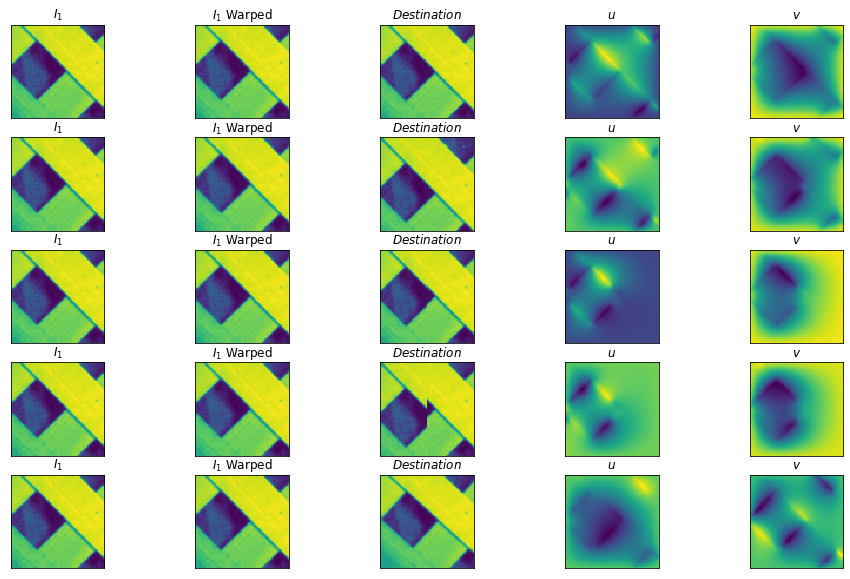

In [55]:
fig, ax = plt.subplots(len(I_t_arr), 5, figsize=(16, 10))
for i in range(len(warped_arr)):
    j = 0
    
    _ = ax[i,j].imshow(img1, interpolation="None")
    ax[i,j].set_xticks([]), ax[i,j].set_yticks([])
    ax[i,j].set_title("$I_1$")
    j += 1
    
    _ = ax[i,j].imshow(warped_arr[i], interpolation="None")
    ax[i,j].set_xticks([]), ax[i,j].set_yticks([])
    ax[i,j].set_title("$I_1$ Warped")
    j += 1
    
    _ = ax[i,j].imshow(dest_arr[i], interpolation="None")
    ax[i,j].set_xticks([]), ax[i,j].set_yticks([])
    ax[i,j].set_title("$Destination$")
    j += 1
    
    _ = ax[i,j].imshow(u_arr[i], interpolation="None")
    ax[i,j].set_xticks([]), ax[i,j].set_yticks([])
    ax[i,j].set_title("$u$")
    j += 1
    
    _ = ax[i,j].imshow(v_arr[i], interpolation="None")
    ax[i,j].set_xticks([]), ax[i,j].set_yticks([])
    ax[i,j].set_title("$v$")